In [1]:
from tensorflow import keras
from tensorflow.keras.models import load_model
import pickle

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from scipy import interp
from sklearn.model_selection import StratifiedKFold

import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pandas as pd
import glob 
import os 

In [2]:
models = glob.glob('/Users/home/Documents/Respiratory Illness AI/k_fold/0_run/*/')

In [3]:
fh = open("/Users/home/Documents/Respiratory Illness AI/datasets/official_datasets/asthma_copd_covid_healthy_224_224_3", 'rb')
dataset = pickle.load(fh)

In [8]:
def train_val(dataset):
    input_shape = (224, 224, 3)
    train = dataset[:278]
    val = dataset[278:]
    #278 - 5, 261 - 4
    #130 - 4, 139 - 5

    X_train, y_train = zip(*train)
    X_val, y_val = zip(*val)

    X_train = np.array([x.reshape(input_shape) for x in X_train])
    X_val = np.array([x.reshape(input_shape) for x in X_val])

    y_train = np.array(np_utils.to_categorical(y_train, 4))
    y_val = np.array(np_utils.to_categorical(y_val, 4))
    
    return X_val, y_val 

In [5]:
def get_auc_values(y_val, y_score):
    fpr, tpr, roc_auc, thresholds = {}, {}, {}, {}
    
    for i in range(4):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_val[:,i], y_score[:,i], drop_intermediate=False)
        # maybe change to roc_auc_score
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return fpr, tpr, roc_auc 

In [12]:
def reorder_list(lst):
    new = []
    
    for i in range(len(lst[0])):
        temp = []
        for group in lst: 
            temp.append(group[i])
        new.append(temp)
    
    return new 

In [14]:
def graph_rocs(tprs, fprs, aucs):
    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow"])
    diseases = ["healthy", "asthma", "copd", "covid"]
    lw = 2
    
    plt.figure(figsize=(5, 5))
    plt.axes().set_aspect('equal', 'datalim')
    
    for i, colour in zip(range(4), colors):
        mean_tpr = np.mean(tprs[i], axis=0)
        mean_tpr[-1] = 1.0
        # change denominator depending on kfold 
        mean_auc = sum(aucs[i])/5
        print(mean_auc)
        plt.plot(fpr[i], mean_tpr, color=colour,
         label=f'ROC class {diseases[i]} (AUC = {round(mean_auc, 2)})',lw=2, alpha=1)

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

0.781439393939394
0.6706018518518518
0.951851851851852
0.695138888888889


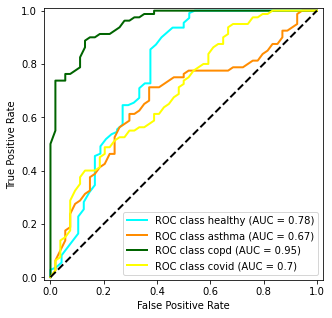

In [15]:
tprs, fprs, roc_aucs = [], [], []

for i in models:
    model = load_model(i, compile = True)
    X_val, y_val = train_val(dataset)
    y_score = model.predict(X_val)
    fpr, tpr, roc_auc = get_auc_values(y_val, y_score)
    
    tprs.append(tpr)
    fprs.append(fpr)
    roc_aucs.append(roc_auc)
        
tprs = reorder_list(tprs)
fprs = reorder_list(fprs)
roc_aucs = reorder_list(roc_aucs)

graph_rocs(tprs, fprs, roc_aucs)